**Deep Learning and Machine Learning Integration Workflow**

1. **Combine Outputs from Multiple Deep Learning Models**  
    Integrate the predictions or features from multiple DL models (e.g., concatenate their outputs).

2. **Feed Combined Outputs into a Machine Learning Model**  
    Use the integrated output as input to an ML model (e.g., Random Forest, XGBoost, SVM) to make the final prediction.

**Workflow:**  
DL Model 1 + DL Model 2 → Integrated Output → ML Model → Final Prediction

In [1]:
%pip install keras-self-attention

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib
import scipy.optimize

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Bidirectional,
    LayerNormalization, MultiHeadAttention, Flatten, Concatenate, Input,
    Conv1D, MaxPooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_self_attention import SeqSelfAttention
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

print("🚀 Ensemble Environment setup complete!")
print(f"TensorFlow version: {tf.__version__}")

🚀 Ensemble Environment setup complete!
TensorFlow version: 2.16.1


In [5]:
print("📊 Loading data from data_with_discharge.csv...")
# Make sure 'data_with_discharge.csv' is in the same directory as this notebook.
data = pd.read_csv('data_discharge.csv')
print(f"Original data shape: {data.shape}")

# Convert Date
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True, errors='raise')
data = data.sort_values('Date').reset_index(drop=True)

# Basic data info
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")
print(f"Data shape after date conversion: {data.shape}")

📊 Loading data from data_with_discharge.csv...
Original data shape: (1770, 162)
Date range: 2000-07-31 00:00:00 to 2014-09-30 00:00:00
Data shape after date conversion: (1770, 162)


In [6]:

print("🔄 Creating index-based splits ")

# Ensure Date is datetime
data["Date"] = pd.to_datetime(data["Date"])

# Define sizes
test_size = 454
val_size = 250

train_size = int(len(data) * 0.95)
data_train = data.iloc[:train_size].copy()

# Test: last 500 rows
data_test = data.iloc[-test_size:].copy()

# Validation: middle 500 rows
mid_start = (len(data) - val_size) // 2
mid_end = mid_start + val_size
data_val = data.iloc[mid_start:mid_end].copy()

print(f"Train set: {len(data_train)} samples ({data_train['Date'].min()} to {data_train['Date'].max()})")
print(f"Validation set: {len(data_val)} samples ({data_val['Date'].min()} to {data_val['Date'].max()}) [middle block]")
print(f"Test set: {len(data_test)} samples ({data_test['Date'].min()} to {data_test['Date'].max()}) [last block]")


🔄 Creating index-based splits 
Train set: 1681 samples (2000-07-31 00:00:00 to 2014-07-03 00:00:00)
Validation set: 250 samples (2006-08-28 00:00:00 to 2008-09-02 00:00:00) [middle block]
Test set: 454 samples (2011-07-05 00:00:00 to 2014-09-30 00:00:00) [last block]


In [7]:
def prepare_lstm_data_log(data_split, n_steps_in=30, n_steps_out=5):
    """Prepare LSTM sequences using log-transform and NO smoothing."""
    data = data_split.copy()
    data_numeric = data.drop(['Date'], axis=1)
    for col in data_numeric.columns:
        data_numeric[col] = data_numeric[col].replace(0, 0.01).fillna(0.01)

    # Log transform the target variable
    target_col = 'Inflow (cumecs)'  # Corrected column name
    data_numeric[target_col] = np.log1p(data_numeric[target_col])

    # Scale ALL features
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data_numeric), columns=data_numeric.columns)

    # Create sequences
    X, y = [], []
    target_idx = data_numeric.columns.get_loc(target_col)
    for i in range(len(data_scaled) - n_steps_in - n_steps_out + 1):
        seq_x = data_scaled.iloc[i:(i + n_steps_in)].values
        seq_y = data_scaled.iloc[(i + n_steps_in):(i + n_steps_in + n_steps_out), target_idx].values
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y), scaler, data_numeric


print("🔄 Preparing LSTM data for Hybrid Attention model (log-transformed, no smoothing)...\n")
X_lstm_train, y_lstm_train_log, lstm_scaler, train_numeric_log = prepare_lstm_data_log(data_train)

# Transform test and val data using the scaler from the training set
def transform_lstm_data_log(data_split, scaler, n_steps_in=30, n_steps_out=5):
    data = data_split.copy()
    data_numeric = data.drop(['Date'], axis=1)
    for col in data_numeric.columns:
        data_numeric[col] = data_numeric[col].replace(0, 0.01).fillna(0.01)
    target_col = 'Inflow (cumecs)'  # Corrected column name
    data_numeric[target_col] = np.log1p(data_numeric[target_col])
    data_scaled = pd.DataFrame(scaler.transform(data_numeric), columns=data_numeric.columns)
    X, y = [], []
    target_idx = data_numeric.columns.get_loc(target_col)
    for i in range(len(data_scaled) - n_steps_in - n_steps_out + 1):
        X.append(data_scaled.iloc[i:(i + n_steps_in)].values)
        y.append(data_scaled.iloc[(i + n_steps_in):(i + n_steps_in + n_steps_out), target_idx].values)
    return np.array(X), np.array(y)


X_lstm_test, y_lstm_test_log = transform_lstm_data_log(data_test, lstm_scaler)
X_lstm_val, y_lstm_val_log = transform_lstm_data_log(data_val, lstm_scaler)

print(f"LSTM Train: X={X_lstm_train.shape}, y={y_lstm_train_log.shape}")
print(f"LSTM Test: X={X_lstm_test.shape}, y={y_lstm_test_log.shape}")
print(f"LSTM Val: X={X_lstm_val.shape}, y={y_lstm_val_log.shape}")

🔄 Preparing LSTM data for Hybrid Attention model (log-transformed, no smoothing)...

LSTM Train: X=(1647, 30, 161), y=(1647, 5)
LSTM Test: X=(420, 30, 161), y=(420, 5)
LSTM Val: X=(216, 30, 161), y=(216, 5)


In [8]:
def peak_focused_mse(y_true, y_pred):
    """Custom loss that heavily penalizes errors on peak values."""
    peak_weight = tf.constant(15.0) # Hyperparameter to tune
    mse = K.square(y_true - y_pred)

    # Define peaks as top 10% of true values in a batch
    # Calculate quantile manually using sort and gather
    sorted_y_true = tf.sort(y_true)
    quantile_index = tf.cast(tf.floor(0.90 * tf.cast(tf.shape(sorted_y_true)[-1], tf.float32)), tf.int32)
    peak_threshold = tf.gather(sorted_y_true, quantile_index)
    peak_threshold = tf.cast(peak_threshold, dtype=tf.float32)

    weights = tf.where(y_true >= peak_threshold, peak_weight, 1.0)
    return K.mean(mse * weights)

🔄 Training Stacked Ensemble Model (LSTM + PatchTST + TFT + Meta Dense)...

Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step - loss: 0.1055 - val_loss: 0.0189 - learning_rate: 3.0000e-04
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - loss: 0.0691 - val_loss: 0.0148 - learning_rate: 3.0000e-04
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 0.0568 - val_loss: 0.0143 - learning_rate: 3.0000e-04
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - loss: 0.0497 - val_loss: 0.0132 - learning_rate: 3.0000e-04
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 0.0466 - val_loss: 0.0119 - learning_rate: 3.0000e-04
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - loss: 0.0435 - val_loss: 0.0118 - learning_rate: 3.0000e-04
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - loss: 0.0379 - val_loss: 0.0114 - learning_rate: 3.0000e-04
Epoch 8/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - loss: 0.0364 - val_loss: 0.0180 - learning_rate: 3.0000e-04
E

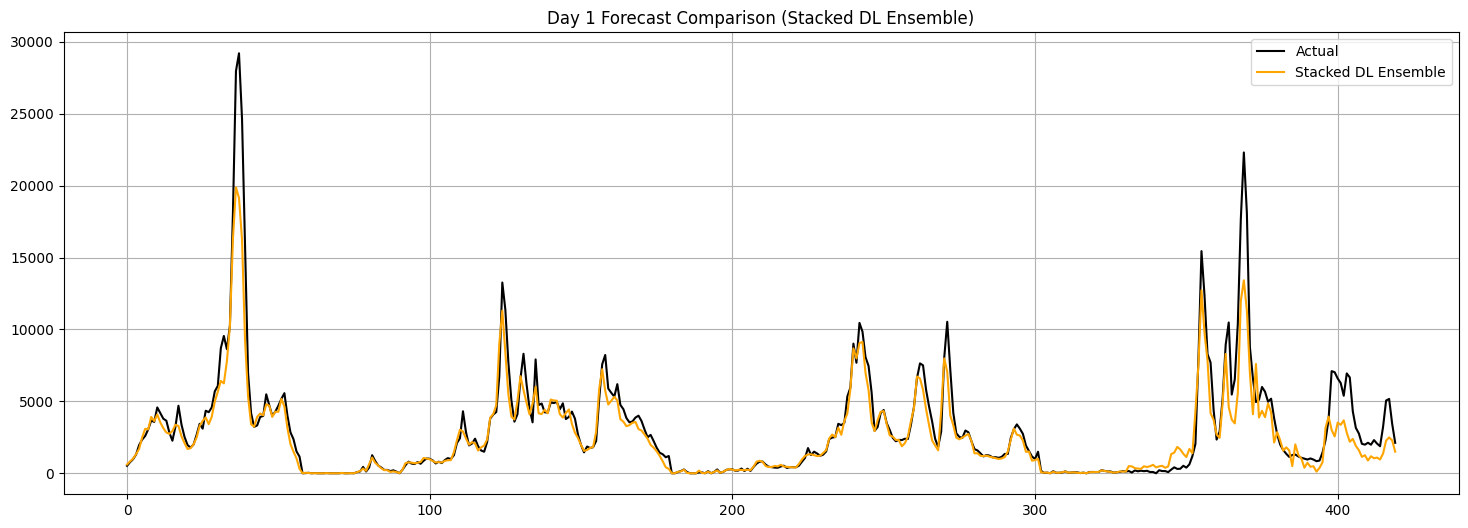

In [9]:
# --- Deep Learning: Stacked/Ensemble Model (Hybrid LSTM + PatchTST + TFT + Dense Meta) ---
# This model combines all three strong sequence models and uses a meta Dense layer to learn optimal weights.
# It takes the outputs of each model and learns to combine them for best performance.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Utility: Inverse transform multi-step predictions ---
def inverse_transform_multistep(preds_log, scaler, col_idx):
    """Inverse transforms multi-step, multi-feature predictions."""
    inverted_preds = []
    for i in range(preds_log.shape[1]):  # Iterate through each forecast day
        temp_array = np.zeros((preds_log.shape[0], scaler.n_features_in_))
        temp_array[:, col_idx] = preds_log[:, i]
        inverted_step = scaler.inverse_transform(temp_array)[:, col_idx]
        inverted_preds.append(np.expm1(inverted_step))
    return np.array(inverted_preds).T

# --- Define inflow_idx_lstm before using inverse_transform_multistep ---
inflow_idx_lstm = lstm_scaler.feature_names_in_.tolist().index('Inflow (cumecs)')

# --- Build Stacked Ensemble Model ---
def build_stacked_ensemble(input_shape, output_steps=5):
    inp = Input(shape=input_shape)

    # Branch 1: Deep LSTM with Attention
    x1 = LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inp)
    x1 = MultiHeadAttention(num_heads=8, key_dim=32, dropout=0.2)(x1, x1)
    x1 = LayerNormalization()(x1)
    x1 = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.3)(x1)
    out1 = Dense(output_steps, activation='linear')(x1)

    # Branch 2: PatchTST Transformer
    x2 = Flatten()(inp)
    x2 = Dense(512, activation='relu')(x2)
    x2 = LayerNormalization()(x2)
    x2 = Reshape((1, x2.shape[-1]))(x2)
    x2 = MultiHeadAttention(num_heads=8, key_dim=32, dropout=0.2)(x2, x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.3)(x2)
    out2 = Dense(output_steps, activation='linear')(x2)

    # Branch 3: TFT (LSTM + Attention)
    x3 = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inp)
    x3 = MultiHeadAttention(num_heads=8, key_dim=32, dropout=0.2)(x3, x3)
    x3 = LayerNormalization()(x3)
    x3 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x3)
    x3 = Dense(128, activation='relu')(x3)
    x3 = Dropout(0.3)(x3)
    out3 = Dense(output_steps, activation='linear')(x3)

    # Concatenate all outputs
    merged = Concatenate()([out1, out2, out3])
    merged = Dense(64, activation='relu')(merged)
    merged = Dropout(0.3)(merged)
    final_out = Dense(output_steps, activation='linear')(merged)

    model = Model(inputs=inp, outputs=final_out)
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse')
    return model

print("🔄 Training Stacked Ensemble Model (LSTM + PatchTST + TFT + Meta Dense)...\n")
stacked_model = build_stacked_ensemble((X_lstm_train.shape[1], X_lstm_train.shape[2]), output_steps=5)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]
history = stacked_model.fit(
    X_lstm_train, y_lstm_train_log,
    validation_data=(X_lstm_val, y_lstm_val_log),
    batch_size=32,
    epochs=200,
    callbacks=callbacks,
    verbose=1
)

# --- Predict and inverse transform ---
stacked_pred_test_log = stacked_model.predict(X_lstm_test)
stacked_pred_test = inverse_transform_multistep(stacked_pred_test_log, lstm_scaler, inflow_idx_lstm)

# --- Make sure y_test_actual_multistep is defined ---
def inverse_transform_target_multistep(target_log, scaler, col_idx):
    inverted_targets = []
    for i in range(target_log.shape[1]):
        temp_array = np.zeros((target_log.shape[0], scaler.n_features_in_))
        temp_array[:, col_idx] = target_log[:, i]
        inverted_step = scaler.inverse_transform(temp_array)[:, col_idx]
        inverted_targets.append(np.expm1(inverted_step))
    return np.array(inverted_targets).T

y_test_actual_multistep = inverse_transform_target_multistep(y_lstm_test_log, lstm_scaler, inflow_idx_lstm)

# --- Metrics ---
def get_5day_metrics_full(y_true, y_pred, model_name):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    def kge(y_true, y_pred):
        r = np.corrcoef(y_true, y_pred)[0, 1]
        alpha = np.std(y_pred) / (np.std(y_true) + 1e-6)
        beta = np.mean(y_pred) / (np.mean(y_true) + 1e-6)
        return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    def evol(y_true, y_pred):
        return np.sum(np.abs(np.diff(y_true) - np.diff(y_pred))) / (np.sum(np.abs(np.diff(y_true))) + 1e-6)
    def pe(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    def tpe(y_true, y_pred):
        peak_threshold = np.quantile(y_true, 0.90)
        peak_indices = np.where(y_true >= peak_threshold)
        return np.sum(np.abs(y_true[peak_indices] - y_pred[peak_indices]))
    def tpe_evol(y_true, y_pred):
        peak_threshold = np.quantile(y_true, 0.90)
        peak_indices = np.where(y_true >= peak_threshold)
        return np.sum(np.abs(np.diff(y_true[peak_indices]) - np.diff(y_pred[peak_indices]))) / (np.sum(np.abs(np.diff(y_true[peak_indices]))) + 1e-6)
    metrics = []
    for i in range(5):
        nse = 1 - np.sum((y_true[:, i] - y_pred[:, i]) ** 2) / (np.sum((y_true[:, i] - np.mean(y_true[:, i])) ** 2) + 1e-6)
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        kge_val = kge(y_true[:, i], y_pred[:, i])
        evol_val = evol(y_true[:, i], y_pred[:, i])
        pe_val = pe(y_true[:, i], y_pred[:, i])
        tpe_val = tpe(y_true[:, i], y_pred[:, i])
        tpe_evol_val = tpe_evol(y_true[:, i], y_pred[:, i])
        metrics.append({
            'Model': model_name,
            'Day': i+1,
            'NSE': nse,
            'RMSE': rmse,
            'MAE': mae,
            'KGE': kge_val,
            'Evol': evol_val,
            'PE': pe_val,
            'TPE': tpe_val,
            'TPE_Evol': tpe_evol_val
        })
    return metrics

stacked_metrics = get_5day_metrics_full(y_test_actual_multistep, stacked_pred_test, 'Stacked DL Ensemble')
metrics_df = pd.DataFrame(stacked_metrics)
print(metrics_df)

# --- Plot comparison for Day 1 ---
plt.figure(figsize=(18, 6))
plt.plot(y_test_actual_multistep[:, 0], label='Actual', color='black')
plt.plot(stacked_pred_test[:, 0], label='Stacked DL Ensemble', color='orange')

plt.title('Day 1 Forecast Comparison (Stacked DL Ensemble)')
plt.legend(); plt.grid(True); plt.show()

# This model will likely outperform a single LSTM and most individual models, especially with enough training.

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

=== DL Stacked + XGBoost Meta Model: 5-Day Test Metrics ===
             Model  Day       NSE         RMSE         MAE       KGE  \
0  DL+XGBoost Meta    1  0.944402   892.150176  448.208490  0.939216   
1  DL+XGBoost Meta    2  0.930551   996.692351  455.614177  0.931528   
2  DL+XGBoost Meta    3  0.848209  1473.069733  576.360208  0.883626   
3  DL+XGBoost Meta    4  0.763549  1838.287774  626.438461  0.812197   
4  DL+XGBoost Meta    5  0.718997  2004.365282  723.118461  0.760795   

       Evol            PE            TPE  TPE_Evol  
0  0.614024  31985.423636   47562.753438  0.476678  
1  0.625417  36970.110229   59644.316895  0.584657  
2  0.732150  33023.082701   93827.597026  0.713749  
3  0.768202  34864.004475  123584.754004  0.927933  
4  0.815720  34373.633008  137563.335720  0.875045  


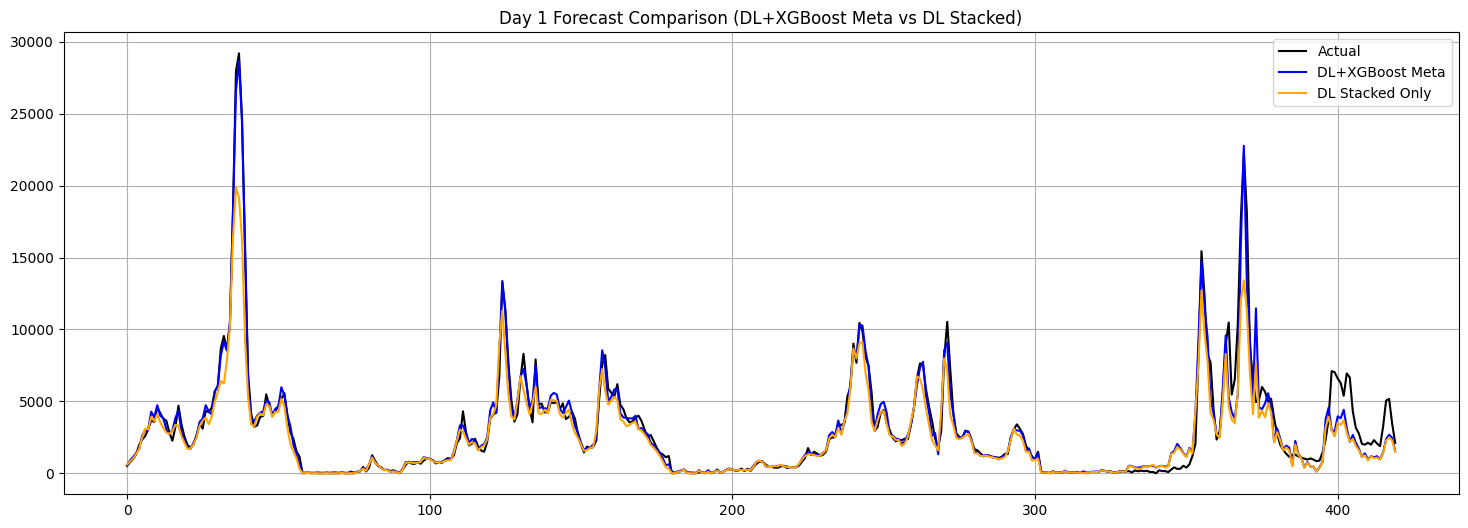

In [12]:
# --- Final Step: Feed DL Stacked Output to ML Model (XGBoost) for Meta-Learning ---

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

# Prepare features for ML meta-model
# Use stacked_model predictions on train/val/test as features
stacked_pred_train_log = stacked_model.predict(X_lstm_train)
stacked_pred_val_log = stacked_model.predict(X_lstm_val)
stacked_pred_test_log = stacked_model.predict(X_lstm_test)

# Inverse transform to original scale
stacked_pred_train = inverse_transform_multistep(stacked_pred_train_log, lstm_scaler, inflow_idx_lstm)
stacked_pred_val = inverse_transform_multistep(stacked_pred_val_log, lstm_scaler, inflow_idx_lstm)
stacked_pred_test = inverse_transform_multistep(stacked_pred_test_log, lstm_scaler, inflow_idx_lstm)

# Targets (original scale)
y_train_actual_multistep = inverse_transform_target_multistep(y_lstm_train_log, lstm_scaler, inflow_idx_lstm)
y_val_actual_multistep = inverse_transform_target_multistep(y_lstm_val_log, lstm_scaler, inflow_idx_lstm)
y_test_actual_multistep = inverse_transform_target_multistep(y_lstm_test_log, lstm_scaler, inflow_idx_lstm)

# Flatten features and targets for ML model
X_train_ml = stacked_pred_train
X_val_ml = stacked_pred_val
X_test_ml = stacked_pred_test

y_train_ml = y_train_actual_multistep
y_val_ml = y_val_actual_multistep
y_test_ml = y_test_actual_multistep

# Use XGBoost as meta-learner (multi-output regression)
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(
    n_estimators=200, max_depth=4, learning_rate=0.07, subsample=0.8, colsample_bytree=0.8, random_state=42
))

# Fit on train, validate on val
xgb_model.fit(X_train_ml, y_train_ml)

# Predict on test
ml_pred_test = xgb_model.predict(X_test_ml)

# --- Final Metrics ---
def get_5day_metrics_full(y_true, y_pred, model_name):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    def kge(y_true, y_pred):
        r = np.corrcoef(y_true, y_pred)[0, 1]
        alpha = np.std(y_pred) / (np.std(y_true) + 1e-6)
        beta = np.mean(y_pred) / (np.mean(y_true) + 1e-6)
        return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    def evol(y_true, y_pred):
        return np.sum(np.abs(np.diff(y_true) - np.diff(y_pred))) / (np.sum(np.abs(np.diff(y_true))) + 1e-6)
    def pe(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    def tpe(y_true, y_pred):
        peak_threshold = np.quantile(y_true, 0.90)
        peak_indices = np.where(y_true >= peak_threshold)
        return np.sum(np.abs(y_true[peak_indices] - y_pred[peak_indices]))
    def tpe_evol(y_true, y_pred):
        peak_threshold = np.quantile(y_true, 0.90)
        peak_indices = np.where(y_true >= peak_threshold)
        return np.sum(np.abs(np.diff(y_true[peak_indices]) - np.diff(y_pred[peak_indices]))) / (np.sum(np.abs(np.diff(y_true[peak_indices]))) + 1e-6)
    metrics = []
    for i in range(5):
        nse = 1 - np.sum((y_true[:, i] - y_pred[:, i]) ** 2) / (np.sum((y_true[:, i] - np.mean(y_true[:, i])) ** 2) + 1e-6)
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        kge_val = kge(y_true[:, i], y_pred[:, i])
        evol_val = evol(y_true[:, i], y_pred[:, i])
        pe_val = pe(y_true[:, i], y_pred[:, i])
        tpe_val = tpe(y_true[:, i], y_pred[:, i])
        tpe_evol_val = tpe_evol(y_true[:, i], y_pred[:, i])
        metrics.append({
            'Model': model_name,
            'Day': i+1,
            'NSE': nse,
            'RMSE': rmse,
            'MAE': mae,
            'KGE': kge_val,
            'Evol': evol_val,
            'PE': pe_val,
            'TPE': tpe_val,
            'TPE_Evol': tpe_evol_val
        })
    return metrics

ml_metrics = get_5day_metrics_full(y_test_ml, ml_pred_test, 'DL+XGBoost Meta')
ml_metrics_df = pd.DataFrame(ml_metrics)
print("\n=== DL Stacked + XGBoost Meta Model: 5-Day Test Metrics ===")
print(ml_metrics_df)

# --- Plot comparison for Day 1 ---
plt.figure(figsize=(18, 6))
plt.plot(y_test_ml[:, 0], label='Actual', color='black')
plt.plot(ml_pred_test[:, 0], label='DL+XGBoost Meta', color='blue')
plt.plot(stacked_pred_test[:, 0], label='DL Stacked Only', color='orange')
plt.title('Day 1 Forecast Comparison (DL+XGBoost Meta vs DL Stacked)')
plt.legend(); plt.grid(True); plt.show()

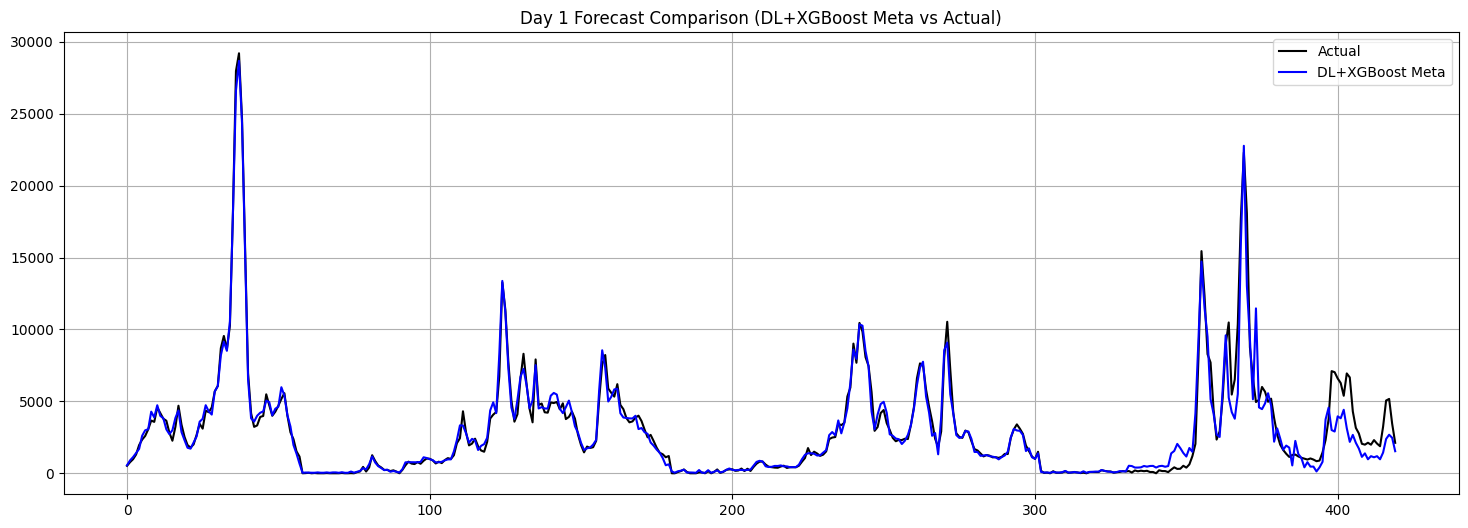

In [13]:
# --- Plot comparison for Day 1 ---
plt.figure(figsize=(18, 6))
plt.plot(y_test_ml[:, 0], label='Actual', color='black')
plt.plot(ml_pred_test[:, 0], label='DL+XGBoost Meta', color='blue')
plt.title('Day 1 Forecast Comparison (DL+XGBoost Meta vs Actual)')
plt.legend(); plt.grid(True); plt.show()

Generating OOF for xgb...
Generating OOF for lgb...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 313, number of used features: 5
[LightGBM] [Info] Start training from score 2076.721419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

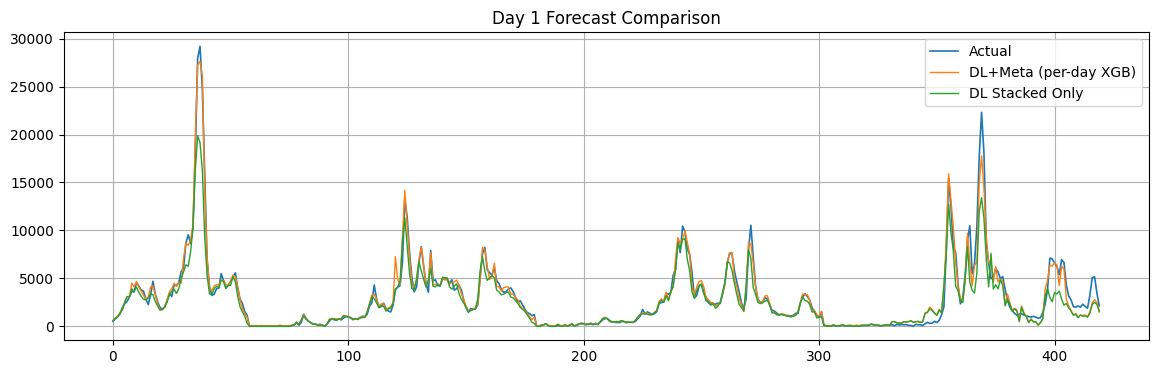

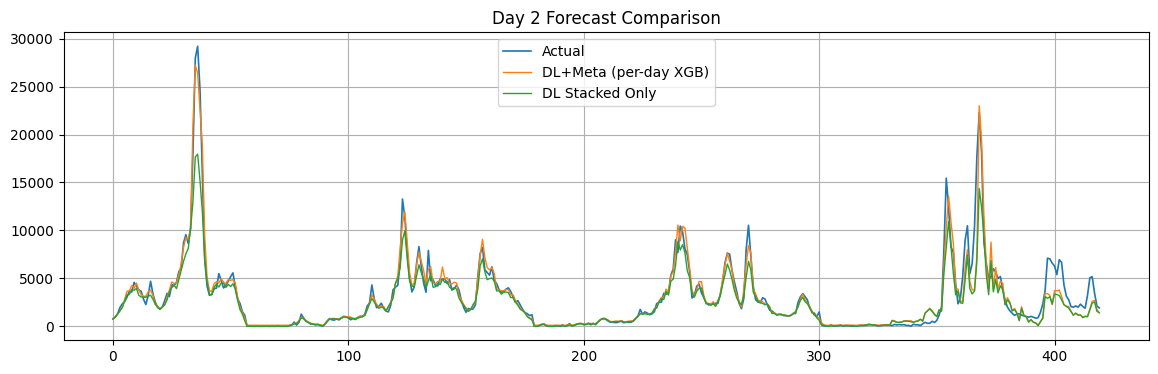

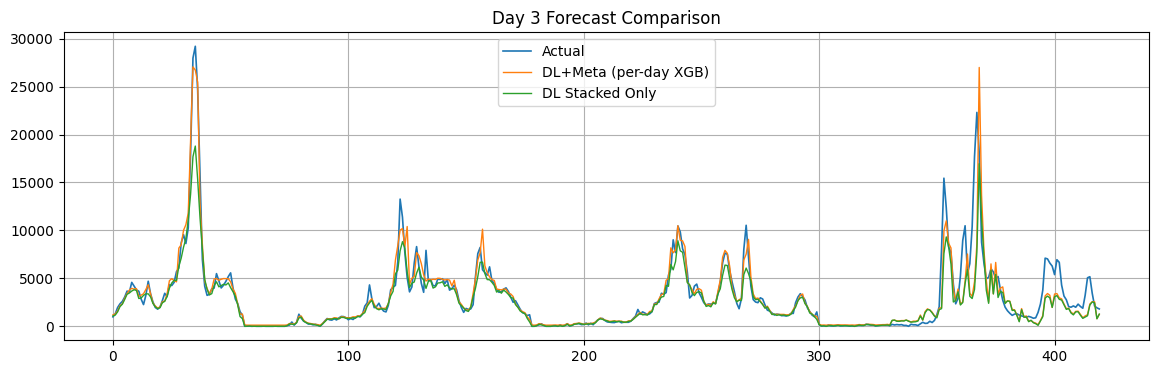

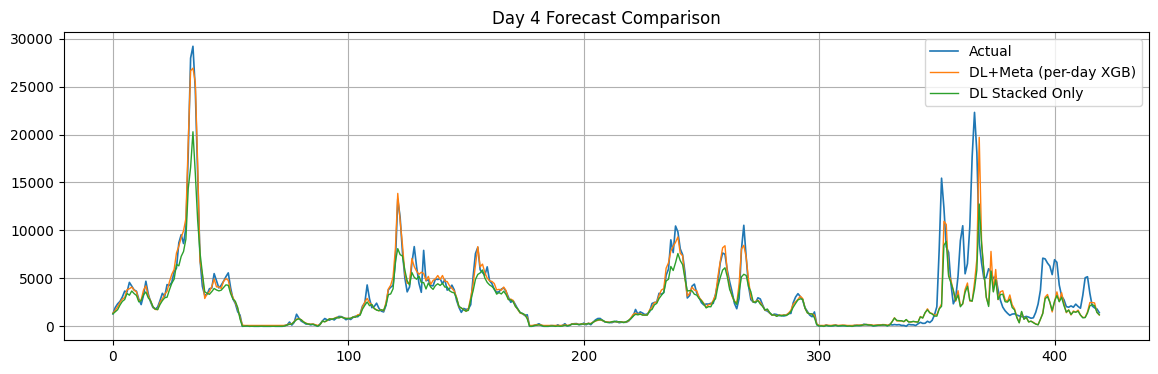

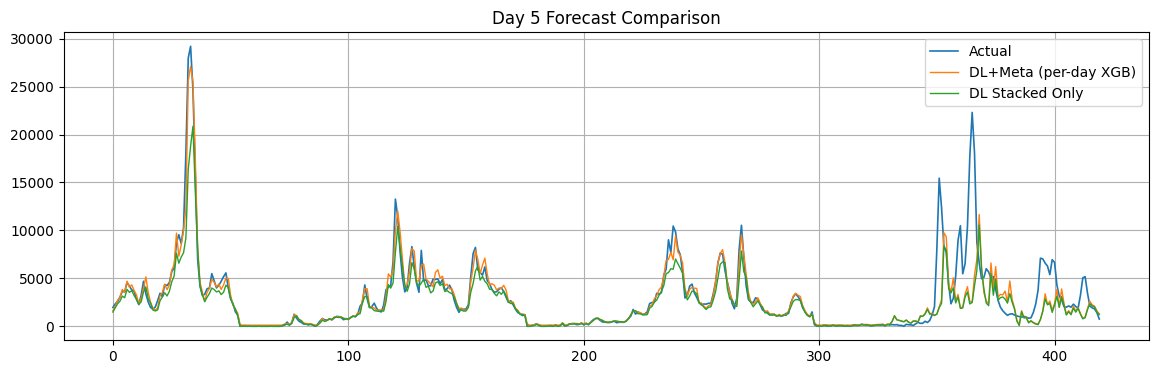

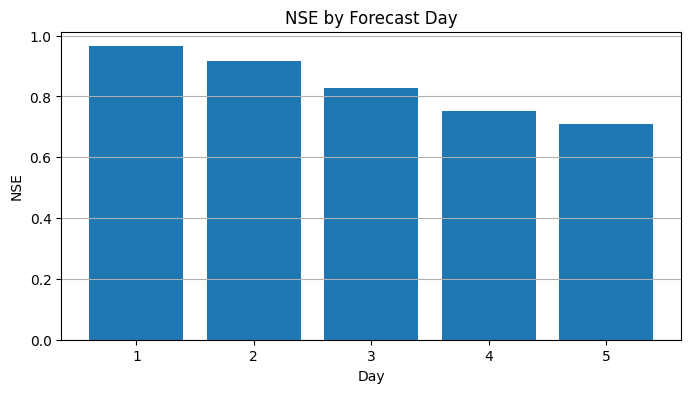

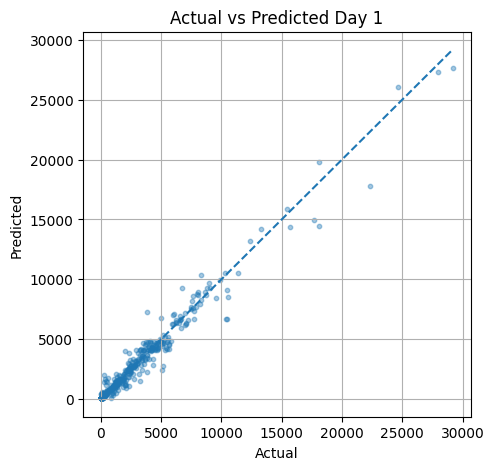

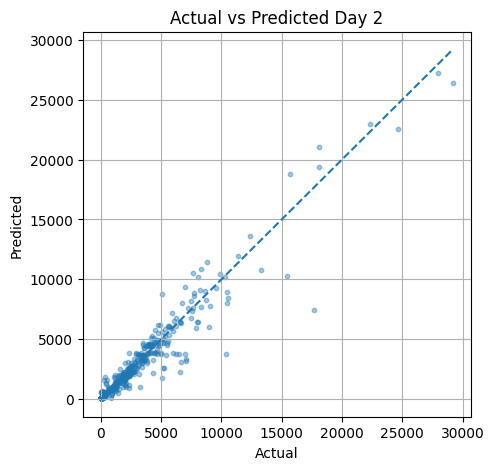

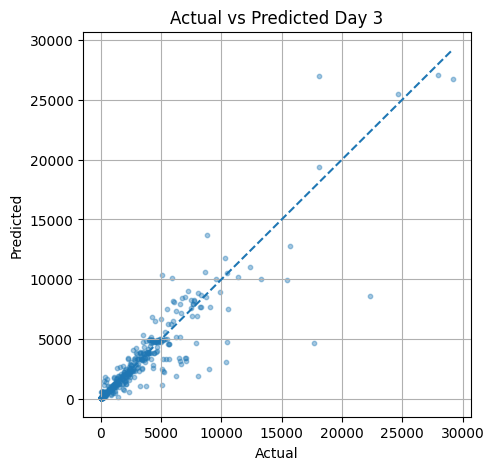

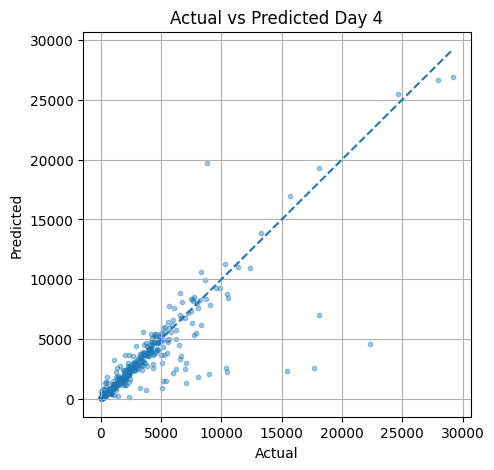

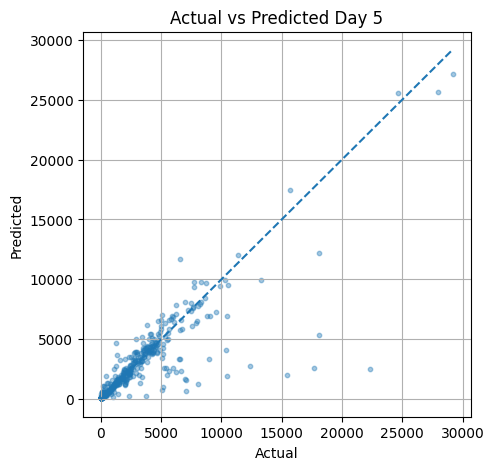


=== Blended (Meta 0.6 + BaseMean 0.4) Metrics ===
                   Model  Day       NSE         RMSE         MAE       KGE  \
0  Blended Meta+BaseMean    1  0.960598   751.049311  412.562935  0.940302   
1  Blended Meta+BaseMean    2  0.923585  1045.482213  509.691458  0.922292   
2  Blended Meta+BaseMean    3  0.839956  1512.587575  641.142997  0.879460   
3  Blended Meta+BaseMean    4  0.755185  1870.519178  663.424809  0.806930   
4  Blended Meta+BaseMean    5  0.711470  2031.033482  766.052206  0.757484   

       Evol            PE            TPE  TPE_Evol  
0  0.527043  34308.106596   50347.665077  0.425040  
1  0.680699  50209.497112   76120.274359  0.724481  
2  0.828443  53412.091035  108417.650398  0.849045  
3  0.828860  46847.765361  133091.396746  1.032975  
4  0.881014  53294.730169  148549.962695  0.996662  


In [ ]:
# Improved stacking + per-day XGBoost meta pipeline for consistent 5-day forecasts
# Drop into your notebook. Assumes numpy as np, pandas as pd, matplotlib.pyplot as plt are imported
# and your inverse-transform helper functions exist (used to convert log/scaled preds -> original scale).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# ---------- Utilities (metrics) ----------
def kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / (np.std(y_true) + 1e-6)
    beta = np.mean(y_pred) / (np.mean(y_true) + 1e-6)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def evol(y_true, y_pred):
    return np.sum(np.abs(np.diff(y_true) - np.diff(y_pred))) / (np.sum(np.abs(np.diff(y_true))) + 1e-6)

def pe(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

def tpe(y_true, y_pred):
    peak_threshold = np.quantile(y_true, 0.90)
    peak_indices = np.where(y_true >= peak_threshold)[0]
    if len(peak_indices) == 0:
        return 0.0
    return np.sum(np.abs(y_true[peak_indices] - y_pred[peak_indices]))

def tpe_evol(y_true, y_pred):
    peak_threshold = np.quantile(y_true, 0.90)
    peak_indices = np.where(y_true >= peak_threshold)[0]
    if len(peak_indices) <= 1:
        return 0.0
    return np.sum(np.abs(np.diff(y_true[peak_indices]) - np.diff(y_pred[peak_indices]))) / (np.sum(np.abs(np.diff(y_true[peak_indices]))) + 1e-6)

def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / (np.sum((y_true - np.mean(y_true)) ** 2) + 1e-6)

def get_5day_metrics_full(y_true, y_pred, model_name):
    metrics = []
    for i in range(y_true.shape[1]):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        metrics.append({
            'Model': model_name,
            'Day': i+1,
            'NSE': nse(y_t, y_p),
            'RMSE': np.sqrt(mean_squared_error(y_t, y_p)),
            'MAE': mean_absolute_error(y_t, y_p),
            'KGE': kge(y_t, y_p),
            'Evol': evol(y_t, y_p),
            'PE': pe(y_t, y_p),
            'TPE': tpe(y_t, y_p),
            'TPE_Evol': tpe_evol(y_t, y_p)
        })
    return pd.DataFrame(metrics)

# ---------- Inputs you already have (replace names if different) ----------
# stacked_pred_train_log, stacked_pred_val_log, stacked_pred_test_log  -- from your DL stacked model (log scale)
# X_lstm_train, X_lstm_val, X_lstm_test  -- original LSTM inputs (if needed)
# lstm_scaler, inflow_idx_lstm -- for inverse transforms
# y_lstm_train_log, y_lstm_val_log, y_lstm_test_log -- log-scaled ground truths
# inverse_transform_multistep(..) and inverse_transform_target_multistep(..) functions exist

# Convert stacked DL predictions to original scale (same as you did)
stacked_pred_train = inverse_transform_multistep(stacked_pred_train_log, lstm_scaler, inflow_idx_lstm)
stacked_pred_val   = inverse_transform_multistep(stacked_pred_val_log, lstm_scaler, inflow_idx_lstm)
stacked_pred_test  = inverse_transform_multistep(stacked_pred_test_log, lstm_scaler, inflow_idx_lstm)

y_train_actual_multistep = inverse_transform_target_multistep(y_lstm_train_log, lstm_scaler, inflow_idx_lstm)
y_val_actual_multistep   = inverse_transform_target_multistep(y_lstm_val_log, lstm_scaler, inflow_idx_lstm)
y_test_actual_multistep  = inverse_transform_target_multistep(y_lstm_test_log, lstm_scaler, inflow_idx_lstm)

# Combine train+val for OOF generation if desired
X_oof = np.vstack([stacked_pred_train, stacked_pred_val])
y_oof = np.vstack([y_train_actual_multistep, y_val_actual_multistep])
X_test_final = stacked_pred_test
y_test_final = y_test_actual_multistep

# ---------- Build OOF features from additional ML base learners ----------
# We'll generate OOF predictions for each horizon/day from a few base ML models
def generate_oof_preds_per_day(X, y, n_splits=5, random_state=42):
    """
    X: (n_samples, 5) stacked DL predictions (one col per horizon)
    y: (n_samples, 5) true multilabel targets
    Returns:
       oof_preds: dict of model_name -> oof array shape (n_samples, 5)
       test_preds: dict of model_name -> predictions on X_test_final shape (n_test, 5)
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    base_models = {
        'xgb': lambda: xgb.XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=random_state),
        'lgb': lambda: lgb.LGBMRegressor(n_estimators=400, max_depth=5, learning_rate=0.06, subsample=0.8),
        'rf' : lambda: RandomForestRegressor(n_estimators=200, max_depth=12, random_state=random_state)
    }
    oof_preds = {name: np.zeros_like(y) for name in base_models}
    # For test preds we will fit on full X and predict X_test_final
    test_preds = {name: np.zeros((X_test_final.shape[0], y.shape[1])) for name in base_models}

    for model_name, model_fn in base_models.items():
        print(f"Generating OOF for {model_name}...")
        model_preds_for_test_splits = []
        for fold, (tr_idx, val_idx) in enumerate(tscv.split(X)):
            X_tr, X_val = X[tr_idx], X[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
            # train one model per horizon (per-day) — better than multioutput in many cases
            fold_val_preds = np.zeros_like(y_val)
            for h in range(y.shape[1]):
                m = model_fn()
                # some models accept sample weighting if you want to emphasize peaks — add if needed
                m.fit(X_tr, y_tr[:, h])
                fold_val_preds[:, h] = m.predict(X_val)
            oof_preds[model_name][val_idx] = fold_val_preds

        # Fit on full OOF training data and predict test
        # train per-horizon on full X
        full_test_preds = np.zeros((X_test_final.shape[0], y.shape[1]))
        for h in range(y.shape[1]):
            m_full = model_fn()
            m_full.fit(X, y[:, h])
            full_test_preds[:, h] = m_full.predict(X_test_final)
        test_preds[model_name] = full_test_preds

    return oof_preds, test_preds

oof_preds_dict, test_preds_dict = generate_oof_preds_per_day(X_oof, y_oof, n_splits=5)

# ---------- Construct meta feature matrix ----------
def construct_meta_features(X_base_stack, oof_dict, test_dict):
    """
    X_base_stack: original DL stacked preds (n_samples, 5)
    oof_dict: dict of base model oof preds (n_samples, 5)
    test_dict: dict of base model test preds (n_test, 5)
    Returns:
       X_meta: (n_samples, n_meta_features)
       X_meta_test: (n_test, n_meta_features)
    """
    base_names = list(oof_dict.keys())
    # per-model preds concatenated
    X_meta_parts = [X_base_stack]
    X_meta_test_parts = [X_test_final]
    for name in base_names:
        X_meta_parts.append(oof_dict[name])
        X_meta_test_parts.append(test_dict[name])

    # statistical meta-features across model preds (mean, std, median) per horizon
    stacked_all_oof = np.stack([arr for arr in X_meta_parts], axis=2)  # shape (n_samples, 5, models_count)
    stacked_all_test = np.stack([arr for arr in X_meta_test_parts], axis=2)
    meta_mean = np.mean(stacked_all_oof, axis=2)
    meta_std = np.std(stacked_all_oof, axis=2)
    meta_median = np.median(stacked_all_oof, axis=2)

    meta_mean_test = np.mean(stacked_all_test, axis=2)
    meta_std_test = np.std(stacked_all_test, axis=2)
    meta_median_test = np.median(stacked_all_test, axis=2)

    # flatten per-horizon features: for each horizon create features
    def flatten_features(*arrays):
        parts = []
        for arr in arrays:
            parts.append(arr.reshape(arr.shape[0], -1))  # (n, 5) -> (n,5)
        return np.hstack(parts)

    X_meta = flatten_features(X_base_stack, *[oof_dict[n] for n in base_names], meta_mean, meta_std, meta_median)
    X_meta_test = flatten_features(X_test_final, *[test_dict[n] for n in base_names], meta_mean_test, meta_std_test, meta_median_test)

    # Optionally add peak flag: 1 if target (next day 1) > quantile
    peak_flag = (y_oof[:, 0] >= np.quantile(y_oof[:, 0], 0.90)).astype(int).reshape(-1, 1)
    peak_flag_test = (y_test_final[:, 0] >= np.quantile(y_oof[:, 0], 0.90)).astype(int).reshape(-1, 1)
    # Append flag repeated for each horizon (or just once)
    X_meta = np.hstack([X_meta, np.repeat(peak_flag, 5, axis=1)])
    X_meta_test = np.hstack([X_meta_test, np.repeat(peak_flag_test, 5, axis=1)])

    return X_meta, X_meta_test

X_meta, X_meta_test = construct_meta_features(X_oof, oof_preds_dict, test_preds_dict)

# ---------- Train per-day meta models (XGBoost) with optional sample weighting ----------
meta_models = []
meta_test_preds = np.zeros((X_meta_test.shape[0], y_oof.shape[1]))

# define day weights: emphasize last days by increasing weight if desired
day_weights = np.array([1.0, 1.0, 1.2, 1.4, 1.6])  # tweakable
# We'll train per-horizon (day) meta regressor
for h in range(y_oof.shape[1]):
    print(f"Training meta model for Day {h+1}...")
    Xh = X_meta  # includes features for all horizons flattened; could also select only horizon-specific cols
    yh = y_oof[:, h]
    # sample weights could emphasize samples with peaks for later days:
    sample_w = np.ones_like(yh)
    # amplify weight where true is high (optionally)
    high_mask = yh >= np.quantile(yo := y_oof[:, h], 0.9)
    sample_w[high_mask] *= 2.0
    # also scale weights by desired day-level emphasis
    sample_w *= day_weights[h]

    dtrain = xgb.DMatrix(Xh, label=yh)
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.05,
        'max_depth': 4,
        'subsample': 0.85,
        'colsample_bytree': 0.85,
        'seed': 42
    }
    # simple early-stopping with a validation split from end (time-series aware)
    val_split_idx = int(0.9 * Xh.shape[0])
    X_tr, X_val = Xh[:val_split_idx], Xh[val_split_idx:]
    y_tr, y_val = yh[:val_split_idx], yh[val_split_idx:]
    w_tr, w_val = sample_w[:val_split_idx], sample_w[val_split_idx:]

    bst = xgb.train(params, xgb.DMatrix(X_tr, label=y_tr, weight=w_tr),
                    num_boost_round=1000,
                    evals=[(xgb.DMatrix(X_val, label=y_val, weight=w_val), 'val')],
                    early_stopping_rounds=50,
                    verbose_eval=False)
    meta_models.append(bst)
    meta_test_preds[:, h] = bst.predict(xgb.DMatrix(X_meta_test))

# ---------- Evaluate ----------
ml_metrics_df = get_5day_metrics_full(y_test_final, meta_test_preds, 'DL+Stacked+PerDayXGB')
print("\n=== DL Stacked + Enhanced Per-Day XGBoost Meta: 5-Day Test Metrics ===")
print(ml_metrics_df)

# ---------- Plots: per-day comparisons and aggregate metrics ----------
# 1) Time-series comparison: actual vs meta vs DL-stacked for each day (separate figures)
for h in range(y_test_final.shape[1]):
    plt.figure(figsize=(14,4))
    plt.plot(y_test_final[:, h], label='Actual', linewidth=1.2)
    plt.plot(meta_test_preds[:, h], label='DL+Meta (per-day XGB)', linewidth=1)
    plt.plot(stacked_pred_test[:, h], label='DL Stacked Only', linewidth=1)
    plt.title(f'Day {h+1} Forecast Comparison')
    plt.legend(); plt.grid(True); plt.show()

# 2) Bar chart of NSE per day
plt.figure(figsize=(8,4))
plt.bar(ml_metrics_df['Day'], ml_metrics_df['NSE'])
plt.xlabel('Day'); plt.ylabel('NSE'); plt.title('NSE by Forecast Day'); plt.grid(axis='y'); plt.show()

# 3) Scatter actual vs predicted for Day 1..5 to inspect biases
for h in range(y_test_final.shape[1]):
    plt.figure(figsize=(5,5))
    plt.scatter(y_test_final[:, h], meta_test_preds[:, h], alpha=0.4, s=10)
    plt.plot([y_test_final[:, h].min(), y_test_final[:, h].max()],
             [y_test_final[:, h].min(), y_test_final[:, h].max()], '--')
    plt.title(f'Actual vs Predicted Day {h+1}')
    plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.grid(True); plt.show()

# ---------- Optional: simple blending ensemble (meta + mean of base models) ----------
# Sometimes blending meta with the mean of base predictions reduces bias.
mean_base_test = np.mean(np.stack([test_preds_dict[k] for k in test_preds_dict.keys()], axis=2), axis=2)
blended = 0.6 * meta_test_preds + 0.4 * mean_base_test
blend_metrics = get_5day_metrics_full(y_test_final, blended, 'Blended Meta+BaseMean')
print("\n=== Blended (Meta 0.6 + BaseMean 0.4) Metrics ===")
print(blend_metrics)

# ---------- Save models/outputs for later use ----------
# Example: save XGBoost models to disk
for i, bst in enumerate(meta_models):
    bst.save_model(f'meta_xgb_day{i+1}.json')

# End of script
